# Itaú Data Meetup #27 Algoritmos Quânticos Híbridos

# Batalha de Quantum Itaú 2023

Autor: José Victor Soares Scursulim

[Linkedin](https://br.linkedin.com/in/jos%C3%A9-victor-soares-scursulim-9406931b4)

## Imports

Lista de bibliotecas

* Qiskit
* Qiskit Optimization
* Qiskit Aer
* Qiskit Algorithms
* SciPy
* CVXPY
* NumPy
* Matplotlib
* Plotly
* Kaleidoscope

In [110]:
import scipy
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

from docplex.mp.model import Model
from kaleidoscope.interactive import bloch_sphere
from matplotlib.colors import LinearSegmentedColormap, rgb2hex
from qiskit.circuit import ClassicalRegister, QuantumRegister, QuantumCircuit, ParameterVector
from qiskit.circuit.library import TwoLocal
from qiskit.primitives import Estimator, Sampler, BackendEstimator, BackendSampler
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram, plot_state_qsphere
from qiskit_aer import Aer, AerSimulator
from qiskit_algorithms.minimum_eigensolvers import NumPyMinimumEigensolver, VQE, QAOA
from qiskit_algorithms.optimizers import COBYLA, SLSQP, SPSA
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit_optimization.translators import from_docplex_mp

Definindo o conversor de problema quadrático para QUBO e o NumPyMinimumEigensolver. Eles vão ser chamados várias vezes durante o código, por isso vamos definir logo no início do notebook para evitar ficar repetindo toda hora.

In [2]:
converter = QuadraticProgramToQubo()
numpy_solver = NumPyMinimumEigensolver()

## 1) QUBO (Quadratic Unconstrained Binary Optimization)

Os problemas de otimização QUBO pertencem a classe de problemas de otimização conhecida como PCBO (Polynomial Combinatorial Binary Optimization), no caso QUBO estamos restritos a problemas binários quadráticos sem restrição, na verdade não é que de fato o problema não possua restrições, mas é que elas são incorporadas a função objetiva através de termos de penalidade. Este termo conta com uma constante que deve ser um número positivo grande para garantir que a resposta do QUBO satisfaça as restrições.

Função objetiva: $\min / \max x^TQx$

Restrição: $Ax=b; \ x \in \{0,1\}^m$

Função objetiva com a penalidade: $\min / \max x^TQx + \lambda(Ax - b)^T(Ax - b)$

![image](penalidade_qubo.png)

Figura retirada da referência [[1]](https://arxiv.org/abs/2307.10379)

Na referência [[2]](https://arxiv.org/abs/1811.11538), encontramos a seguinte lista de problemas de otimização que podem ser resolvidos usando o formalismo QUBO:

* Quadratic Assignment Problems 
* Capital Budgeting Problems 
* Multiple Knapsack Problems 
* Task Allocation Problems (distributed computer systems) 
* Maximum Diversity Problems 
* P-Median Problems 
* Asymmetric Assignment Problems 
* Symmetric Assignment Problems 
* Side Constrained Assignment Problems 
* Quadratic Knapsack Problems 
* Constraint Satisfaction Problems (CSPs)
* Discrete Tomography Problems 
* Set Partitioning Problems 
* Set Packing Problems 
* Warehouse Location Problems 
* Maximum Clique Problems 
* Maximum Independent Set Problems 
* Maximum Cut Problems 
* Graph Coloring Problems 
* Number Partitioning Problems 
* Linear Ordering Problems 
* Clique Partitioning Problems
* SAT problems

## 2) Modelo de Ising

![image](https://ufla.br/dcom/wp-content/uploads/2012/05/RichardFeynman.jpg)

### “Nature isn't classical, dammit, and if you want to make a simulation of nature, you'd better make it quantum mechanical, and by golly it's a wonderful problem, because it doesn't look so easy.” - Richard Feynman

O modelo de Ising é um modelo muito estudado em física estatística no contexto de ferromagnetismo. O curioso é que existe uma transformação que leva um problema de otimização do tipo QUBO em um modelo de Ising, de forma que resolvendo uma equação de autovalor do modelo de Ising para encontrar o autoestado associado ao autovalor de menor energia, estamos resolvendo o problema de otimização, dessa maneira podemos usar um computador quântico para resolver problemas de otimização.

A transformação que leva as variáveis binárias em variáveis spin é a seguinte:
$x_i = \frac{1}{2}(1 + Z_i); \ x_i \in \{0,1\}; \ Z_i \in \{-1,1\}$.

Saindo de uma expressão como a abaixo

$H_{QUBO} = \sum_{i=1}^N a_ix_i + \sum_{i=1}^N\sum_{j=i-1}^N b_{ij}x_ix_j$,
utilizando a transformação de variáveis citada acima e transformando as coeficientes do problema QUBO ($a_i$ e $b_{ij}$) nos coeficientes do modelo de Ising ($h_i$ e $J_{ij}$), obtemos a Hamiltoniana de Ising que mapeia o problema de otimização de interesse

$H_{Ising} = \sum_{i=1}^{N}h_iZ_i + \sum_{i=1}^{N}\sum_{j=1}^{N}J_{ij}Z_iZ_j$.

O autoestado relacionado ao menor autovalor da Hamiltoniana de Ising nos fornece as variáveis respostas do problema de otimização QUBO, enquanto que o menor autovalor deve ser somado a um offset para que represente o valor da função objetiva original.

## 3) Algoritmos Quânticos Variacionais

O princípio variacional da mecânica quântica nos fornece um método para calcular a energia do estado fundamental (o menor autovalor) de uma Hamiltoniana, dado que precisamos estabelecer uma função de onda teste parametrizada que deve ter seus parâmetros atualizados para tentar encontrar a energia mínima. Este princípio também nos diz como estimar o menor autovalor através da expressão abaixo:

$\langle\psi(\vec{\theta})\vert \hat{H} \vert\psi(\vec{\theta})\rangle \equiv \lambda_\theta \geq \lambda_{\min}$.

A expressão acima no formalismo braket, é equivalente a calcular o seguinte produto matricial:

$\langle\psi(\vec{\theta})\vert \hat{H} \vert\psi(\vec{\theta})\rangle \equiv \left[\begin{array}{cccc} a_0^*(\theta) & a_1^*(\theta) & \dots & a_n^*(\theta) \end{array}\right]_{1\times n}\left[\begin{array}{cccc} h_{00} & h_{01} & \dots & h_{0n} \\ h_{10} & h_{11} & \dots & h_{1n} \\ \vdots & \vdots & \ddots & \vdots \\ h_{n0} & h_{n1} & \dots & h_{nn} \end{array}\right]_{n\times n}\left[\begin{array}{c} a_0(\theta) \\ a_1(\theta) \\ \vdots \\ a_n(\theta) \end{array}\right]_{n\times 1}$.

O estado $\vert\psi(\vec{\theta})\rangle$ é preparado através da aplicação de um operador parametrizado da seguinte forma:
$U(\vec{\theta})\vert\psi\rangle \equiv \vert\psi(\vec{\theta})\rangle$.

A partir da teoria do princípio variacional e de conhecimentos de computação quântica, criaram os algoritmos quânticos variacionais. Estes são algoritmos híbridos, ou seja, quânticos e clássicos, onde a parte quântica se resume a preparação da função de onda teste parametrizada, já a parte clássica se resume ao cálculo do valor esperado da Hamiltoniana, a partir das probabilidades medidas da função de onda elaborada, este cálculo entra como uma função de custo em um otimizador clássico que será responsável por atualizar os parâmetros do circuito quântico. Este processo se repete até que um dos critérios de parada seja atingido, ou seja, o número máximo de iterações ou que o menor valor tenha sido alcançado.

$\min \mathcal{C}(\vec{\theta}) = \min \langle\psi(\vec{\theta})\vert \hat{H} \vert\psi(\vec{\theta})\rangle \geq \lambda_{\min}$

Abaixo segue uma figura que ilustra o funcionamento híbrido dos algoritmos quânticos variacionais.

![image](https://media.springernature.com/lw685/springer-static/image/art%3A10.1038%2Fs42254-021-00348-9/MediaObjects/42254_2021_348_Fig2_HTML.png)

Da figura acima, podemos criar um paralelo entre o processo de tunning de hiperparâmetros de uma rede neural com a rotina de um algoritmo quântico variacional para encontrar os parâmetros do circuito quântico que irão minimizar ou maximizar a função de custo do problema de interesse.

Figura retirada do seguinte artigo da revista nature reviews physics: https://www.nature.com/articles/s42254-021-00348-9

### 3.1) Variational Quantum Eigensolver - VQE

O VQE (Variational Quantum Eigensolver), nada mais é do que a implementação do princípio variacional na computação quântica. Inicialmente foi aplicado em estudos de móleculas para ajudar a encontrar a energia do estado fundamental de móleculas e de outros sistemas físicos. Dado que há um paralelo entre modelos de Ising e problemas de otimização tipo QUBO, podemos usar este algoritmo em problemas de otimização, basta passar como argumento a versão Ising do problema de interesse, dessa forma o autovetor que estiver associado com o menor autovalor desse modelo de Ising será a resposta do problema QUBO original. 

#### Exemplo 1: Encontrando o menor autovalor da matriz $Z$
* Estado 0: $\vert 0 \rangle = \left[\begin{array}{c} 1 \\ 0 \end{array}\right]$ e Estado 1: $\vert 1 \rangle = \left[\begin{array}{c} 0 \\ 1 \end{array}\right]$
* Ansatz com um qubit: $\vert\psi(\theta)\rangle = RY(\theta)\vert 0 \rangle = \cos\left(\frac{\theta}{2}\right)\vert 0\rangle + \sin\left(\frac{\theta}{2}\right)\vert 1 \rangle = \left[\begin{array}{c} \cos\left(\frac{\theta}{2}\right) \\ \sin\left(\frac{\theta}{2}\right)\end{array}\right]$
* Matriz de pauli Z: $Z = \left[\begin{array}{cc} 1 & 0 \\ 0 & -1\end{array}\right]$
* Valor esperado de Pauli Z: $\mathcal{C}(\theta) = \langle Z \rangle_\psi = \langle\psi(\theta)\vert Z \vert\psi(\theta)\rangle = \cos^2\left(\frac{\theta}{2}\right) - \sin^2\left(\frac{\theta}{2}\right) = \cos\theta$

Neste exemplo a nossa função de custo será o próprio valor esperado da matriz Pauli Z. Dado que este é um problema bem simples, sabemos de antemão que o $\theta = \pi$ nos leva ao menor valor da função $\mathcal{C}(\theta)$ e que não precisamos de computação quântica para resolvê-lo, mas para fins de ilustração e demonstração do método é um bom ponto de partida.

* Resolvendo o problema na força bruta (maneira menos eficiente)

Expressão literal da função de custo

In [3]:
def cost_function(theta: float) -> float:

    return (np.cos(theta/2))**2 - (np.sin(theta/2))**2

theta_values = np.linspace(0, 2*np.pi, 100).tolist()
expectation_values_z = [cost_function(theta=theta) for theta in theta_values]

In [4]:
min(expectation_values_z)

-0.9994965423831852

In [5]:
idx = expectation_values_z.index(min(expectation_values_z))
angulo = np.linspace(0, 2*np.pi, 100).tolist()[idx]
print(angulo)

3.1098593944626236


Visualização do comportamento da função de custo

In [6]:
px.line(x=theta_values, y=expectation_values_z, labels={"y": "Energia", "x": "theta"})

* Otimizando a função de custo com o auxílio do Scipy através da expressão literal

Definindo os bounds e o ponto inicial da otimização

In [7]:
bounds = [(-np.pi, np.pi)]
x0 = [np.random.random()]
resultado = scipy.optimize.minimize(fun=cost_function, x0=x0, bounds=bounds, method="SLSQP")

In [8]:
resultado

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -1.0
       x: [ 3.142e+00]
     nit: 3
     jac: [-7.451e-09]
    nfev: 6
    njev: 3

O valor de `x` no resultado acima, nos mostra o valor que o nosso parâmetro $\theta$ deve assumir para que o sistema físico representa por $H = Z$, esteja em seu estado fundamental.

* Otimizando a função de custo com o auxílio do Scipy através da expressão matricial

Essa forma de resolver o problema pode ser comparada ao formalismo quadrático de problemas de otimização.  

In [9]:
Z = np.array([[1, 0], [0, -1]])

def objective(theta) -> float:

    psi = np.array([np.cos(theta/2), np.sin(theta/2)])
    cost_function_value = psi.T@Z@psi

    return cost_function_value

Definindo os bounds e o ponto inicial da otimização

In [10]:
bounds = [(-np.pi, np.pi)]
x0 = [np.random.random()]
resultado = scipy.optimize.minimize(fun=objective, x0=x0, bounds=bounds, method="SLSQP")

In [11]:
resultado

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -1.0
       x: [ 3.142e+00]
     nit: 3
     jac: [-7.451e-09]
    nfev: 6
    njev: 3

O valor de `x` no resultado acima, nos mostra o valor que o nosso parâmetro $\theta$ deve assumir para que o sistema físico representa por $H = Z$, esteja em seu estado fundamental.

* Montando a rotina do VQE na mão utilizando um circuito quântico para extrair as probabilidades para calcular o valor esperado de $Z$

Circuito que representa o ansatz para o problema do exemplo proposto aqui

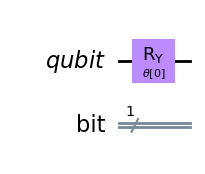

In [111]:
qubit = QuantumRegister(size=1, name="qubit")
bit = ClassicalRegister(size=1, name="bit")
theta = ParameterVector(name=r"$\theta$", length=1)
qc = QuantumCircuit(qubit, bit)
qc.ry(theta=theta[0], qubit=qubit)
qc.draw(output="mpl", style="clifford")

Atribuindo um valor aleatório ao parâmetro do circuito

In [112]:
qc = qc.assign_parameters([np.random.random()*np.pi])

In [113]:
sv = Statevector(qc)

bloch_sphere(vectors=sv)

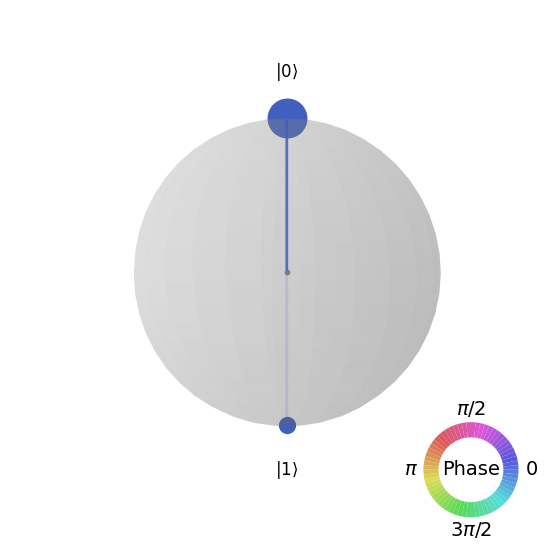

In [114]:
plot_state_qsphere(sv)

Executando 1024 experimentos com o circuito acima

In [27]:
qc.measure(qubit=qubit, cbit=bit)
backend = AerSimulator()
resultado = backend.run(qc, shots=1024).result()
counts = resultado.get_counts()

Frequência de medição dos estados $\vert 0\rangle$ e $\vert 1\rangle$ em 1024 experimentos 

In [28]:
counts

{'1': 1018, '0': 6}

Histograma

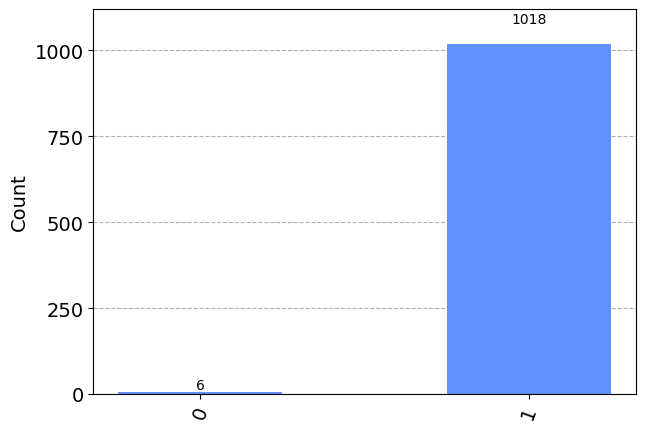

In [29]:
plot_histogram(counts)

Probabilidade de medir o qubit no estado $\vert 0\rangle$

In [30]:
prob_0 = counts["0"]/1024
print(prob_0)

0.005859375


Probabilidade de medir o qubit no estado $\vert 1\rangle$

In [31]:
prob_1 = counts["1"]/1024
print(prob_1)

0.994140625


Verificando que a soma das probabilidades é igual a 1

In [32]:
prob_0 + prob_1

1.0

Definindo a função objetivo com o circuito para extrair a probabilidade

In [33]:
def objective_circuito(x) -> float:

    shots = 1024
    qubit = QuantumRegister(size=1, name="qubit")
    bit = ClassicalRegister(size=1, name="bit")
    theta = ParameterVector(name=r"$\theta$", length=1)
    qc = QuantumCircuit(qubit, bit)
    qc.ry(theta=theta[0], qubit=qubit)
    qc.measure(qubit=qubit, cbit=bit)
    qc = qc.assign_parameters(x)
    backend = AerSimulator()
    resultado = backend.run(qc, shots=shots).result()
    counts = resultado.get_counts()
    try:
        prob_0 = counts["0"]/shots
    except:
        prob_0 = 0
    try:
        prob_1 = counts["1"]/shots
    except:
        prob_1 = 0
    
    psi = np.array([np.sqrt(prob_0), np.sqrt(prob_1)])
    cost_function_value = psi.T@Z@psi

    return cost_function_value

In [34]:
callback_list = []

def callback_func(theta) -> None:
    callback_list.append((theta[0], objective_circuito(x=theta)))

x0 = [np.random.random()]
resultado = scipy.optimize.minimize(fun=objective_circuito, x0=x0, bounds=None, method="cobyla", callback=callback_func)

In [35]:
resultado

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -1.0
       x: [ 3.138e+00]
    nfev: 13
   maxcv: 0.0

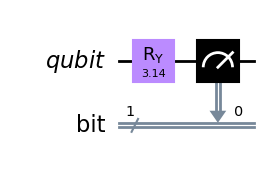

In [36]:
qubit = QuantumRegister(size=1, name="qubit")
bit = ClassicalRegister(size=1, name="bit")
theta = ParameterVector(name=r"$\theta$", length=1)
qc = QuantumCircuit(qubit, bit)
qc.ry(theta=theta[0], qubit=qubit)
qc.measure(qubit=qubit, cbit=bit)
qc = qc.assign_parameters(resultado.x)
qc.draw(output="mpl", style="clifford")

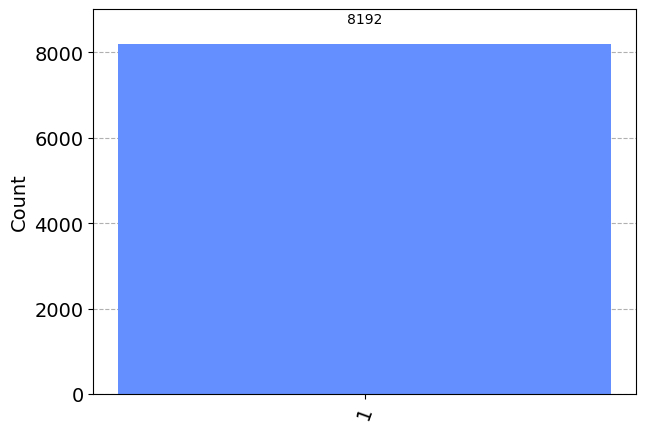

In [37]:
backend = AerSimulator()
resultado = backend.run(qc, shots=8192).result()
counts = resultado.get_counts()
plot_histogram(counts)

In [38]:
callback_list

[(1.6382553013641843, -0.1386718750000001),
 (2.6382553013641843, -0.8945312499999999),
 (3.6382553013641843, -0.9121093749999999),
 (4.138255301364184, -0.552734375),
 (3.3882553013641843, -0.978515625),
 (3.1382553013641843, -1.0),
 (2.8882553013641843, -0.9726562500000001),
 (3.0132553013641843, -0.9882812499999999),
 (3.2007553013641843, -1.0),
 (3.1460678013641843, -1.0),
 (3.1392318638641843, -1.0),
 (3.1383773716766843, -1.0),
 (3.1382553013641843, -1.0)]

In [39]:
px.line(x=[item[0] for item in callback_list],
        y=[item[1] for item in callback_list],
        hover_name=[i+1 for i in range(len(callback_list))],
        markers=True,
        labels={"x": "theta", "y": "Energia"})

In [40]:
cm = LinearSegmentedColormap.from_list('graypurple', ["#999999", "#AA00FF"])

vectors_color = [rgb2hex(cm(kk)) for kk in np.linspace(-1,1,len(callback_list))]

vectors = []

for item in callback_list:
    qubit = QuantumRegister(size=1, name="qubit")
    theta = ParameterVector(name=r"$\theta$", length=1)
    qc = QuantumCircuit(qubit)
    qc.ry(theta=theta[0], qubit=qubit)
    qc = qc.assign_parameters([item[0]])
    sv = Statevector(qc)
    vectors.append(sv)

bloch_sphere(vectors=vectors[:14], vectors_color=vectors_color, figsize=(500, 500))

O valor de `x` no resultado acima, nos mostra o valor que o nosso parâmetro $\theta$ deve assumir para que o sistema físico representa por $H = Z$, esteja em seu estado fundamental.

#### Exemplo 2: Encontrando o menor autovalor de $H = 5ZZ - 3ZI + 4IZ$

In [41]:
hamiltonian = 5*np.kron(Z, Z) - 3*np.kron(Z, np.eye(2)) + 4*np.kron(np.eye(2), Z)

In [42]:
hamiltonian

array([[  6.,   0.,   0.,   0.],
       [  0., -12.,   0.,   0.],
       [  0.,   0.,   2.,   0.],
       [  0.,   0.,   0.,   4.]])

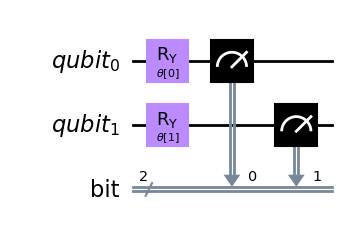

In [43]:
qubit = QuantumRegister(size=2, name="qubit")
bit = ClassicalRegister(size=2, name="bit")
theta = ParameterVector(name=r"$\theta$", length=2)
qc = QuantumCircuit(qubit, bit)
for i in range(2):
    qc.ry(theta=theta[i], qubit=qubit[i])
qc.measure(qubit=qubit, cbit=bit)
qc.draw(output="mpl", style="clifford")

In [44]:
def objective_circuito(x) -> float:

    qubit = QuantumRegister(size=2, name="qubit")
    theta = ParameterVector(name=r"$\theta$", length=2)
    qc = QuantumCircuit(qubit)
    for i in range(2):
        qc.ry(theta=theta[i], qubit=qubit[i])
    qc = qc.assign_parameters(x)
    backend = Aer.get_backend("statevector_simulator")
    resultado = backend.run(qc).result()
    sv = np.array(resultado.get_statevector())

    cost_function_value = np.real(sv@hamiltonian@sv)

    return cost_function_value

In [45]:
callback_list = []

def callback_func(theta) -> None:
    callback_list.append((theta[0], theta[1], objective_circuito(x=theta)))

x0 = [np.random.random() for _ in range(2)]
resultado = scipy.optimize.minimize(fun=objective_circuito, x0=x0, bounds=None, method="cobyla", callback=callback_func)

In [46]:
resultado

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -11.999999946814071
       x: [ 3.141e+00 -3.176e-05]
    nfev: 40
   maxcv: 0.0

In [55]:
cost_function_values = []

for theta0 in np.linspace(-2*np.pi, 2*np.pi, 100):
    for theta1 in np.linspace(-2*np.pi, 2*np.pi, 100):

        psi = np.array([np.cos(theta0/2)*np.cos(theta1/2), 
                        np.cos(theta0/2)*np.sin(theta1/2), 
                        np.sin(theta0/2)*np.cos(theta1/2), 
                        np.sin(theta0/2)*np.sin(theta1/2)])
        cost_function_value = psi.T@hamiltonian@psi
        cost_function_values.append(cost_function_value)

In [56]:
cost_function_values_matrix = np.array(cost_function_values).reshape((100, 100))

In [57]:
cost_function_values_matrix.min()

-11.995468881448666

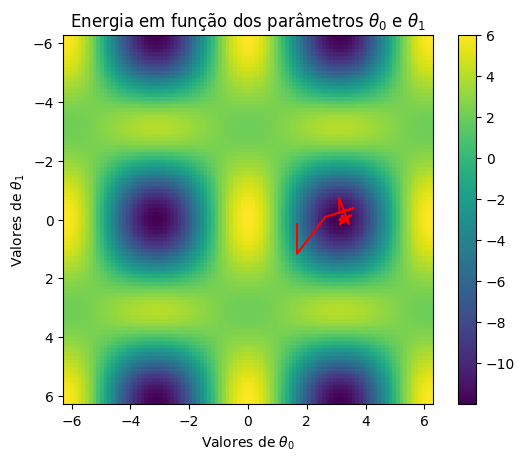

In [61]:
plt.plot([theta0 for theta0, _, _ in callback_list], [theta1 for _, theta1, _ in callback_list], color="red")
plt.imshow(cost_function_values_matrix, extent=(-2*np.pi, 2*np.pi, 2*np.pi, -2*np.pi))
plt.ylabel(r"Valores de $\theta_1$")
plt.xlabel(r"Valores de $\theta_0$")
plt.title(r"Energia em função dos parâmetros $\theta_0$ e $\theta_1$")
plt.colorbar()
plt.show()

In [62]:
surface_plot = go.Surface(x=np.linspace(-2*np.pi, 2*np.pi, 100), y=np.linspace(-2*np.pi, 2*np.pi, 100), z=cost_function_values_matrix, opacity=0.7)
optimizer_path = go.Scatter3d(
    x=[theta0 for theta0, _, _ in callback_list], y=[theta1 for _, theta1, _ in callback_list], z=[np.real(energy) for _, _, energy in callback_list], line=dict(
        color='black',
    )
)
fig = go.Figure(data=[optimizer_path, surface_plot])
fig.show()

Em alguns casos, pode ser que o `VQE` e o `QAOA` não sejam capazes de chegar a melhor solução por diversos motivos: seja pelo uso de um ansatz que não tenha expressividade suficiente para chegar ao melhor resultado, seja porque temos um problema de barren plateaus no landscape do problema, seja porque o ponto inicial foi ruim e entre outros motivos. Neste workshop não vamos falar de ruído no hardware real, mas vale a pena mencionar que o ruído pode induzir barren plateaus.

![image](https://cdn.lanl.gov/ef0ea9c3-cbbc-4859-9714-2915b1c0164a.jpeg)

Figura retirada do site https://discover.lanl.gov/news/0319-barren-plateaus/

### 3.2) Quantum Approximate Optimization Algorithm - QAOA

O `QAOA` é um algoritmo quântico variacional que é inspirado em quantum annealing, cujo objetivo é resolver problemas de otimização combinatória. Este algoritmo prepara um estado $\vert\psi(\beta, \gamma)\rangle$ através da aplicação de uma unitária $U(\beta, \gamma) = U(\beta)U(\gamma)$, cujos parâmetros $\beta$ e $\gamma$ serão otimizados de forma que o estado quântico com os parâmetros otimizados corresponda as variáveis resposta.

Os operadores $U(\beta)$ e $U(\gamma)$ tem a seguinte forma

$U(\beta) = e^{-i\beta H_B}$ e $U(\gamma) = e^{-i\gamma H_P}$,
onde $H_B$ representa a Hamiltoniana de mistura e $H_P$ representa a Hamiltoniana do problema de otimização de interesse. O operador $U(\beta)$ pode ser implementado através da aplicação de portas $RX(h_{ij}\beta)$ em todos os qubits, enquanto que $U(\beta)$ pode ser implementado de várias formas, pois vai depender da estrutura da matriz da Hamiltoniana do problema, caso ela tenha elementos apenas na diagonal principal, a implementação será igual a aplicação de portas $RZ(h_{ij}\gamma)$. Entretanto, se tivermos elementos da Hamiltoniana que indicam uma interação entre 2 qubits, será necessário aplicar uma porta CNOT antes e depois da porta $RZ(h_{ij}\gamma)$. Comentário sobre exponencial...

* Unidade imaginária: $i = \sqrt{-1}; \ i^2 = -1$
* Propriedade matriz de Pauli: $\sigma_i^2 = \mathbb{I}; \ i=x,y,z$ (Lembrando que: $\sigma_x = X$, $\sigma_y = Y$ e $\sigma_z = Z$)
* $\mathbb{I}^n = \mathbb{I}$

* Expansão em série de Taylor da função exponencial
$e^x = \sum_{n=0}^\infty\frac{x^n}{n!}$

$e^{-i\frac{\theta}{2}X} = \sum_{n=0}^\infty \frac{(-i\frac{\theta}{2} X)^n}{n!} = \sum_{n=0}^\infty \frac{(-i\frac{\theta}{2} X)^{2n}}{2n!} + \sum_{n=0}^\infty \frac{(-i\frac{\theta}{2} X)^{2n+1}}{(2n+1)!}$

Continuando a conta...

$= \sum_{n=0}^\infty ((-i)^2)^n\frac{(\frac{\theta}{2})^{2n}}{2n!}(X^2)^n + \sum_{n=0}^\infty -i((-i)^2)^n\frac{(\frac{\theta}{2})^{2n+1}}{(2n+1)!}X(X^2)^n$

$= \sum_{n=0}^\infty (-1)^n\frac{(\frac{\theta}{2})^{2n}}{2n!}(\mathbb{I})^n - i\sum_{n=0}^\infty (-1)^n\frac{(\frac{\theta}{2})^{2n+1}}{(2n+1)!}X(\mathbb{I})^n$

$= \sum_{n=0}^\infty (-1)^n\frac{(\frac{\theta}{2})^{2n}}{2n!}\mathbb{I} - i\sum_{n=0}^\infty (-1)^n\frac{(\frac{\theta}{2})^{2n+1}}{(2n+1)!}X$

* Expansão em série de Taylor da função cosseno

$\cos\theta = \sum_{n=0}^\infty (-1)^n\frac{\theta^{2n}}{2n!}$

* Expansão em série de Taylor da função seno

$\sin\theta = \sum_{n=0}^\infty (-1)^n\frac{\theta^{2n+1}}{(2n+1)!}$

Usando os resultados acima chegamos em:

$e^{-i\frac{\theta}{2}X} = \cos\left(\frac{\theta}{2}\right)\mathbb{I} -i\sin\left(\frac{\theta}{2}\right)X = \left[\begin{array}{cc} \cos\left(\frac{\theta}{2}\right) & -i\sin\left(\frac{\theta}{2}\right) \\ -i\sin\left(\frac{\theta}{2}\right) & \cos\left(\frac{\theta}{2}\right) \end{array}\right] = RX(\theta)$

Outra forma de ver isso é usando 

* Fórmula de Euler:
$e^{i\theta} = (\cos\theta + i\sin\theta)$

* Aplicando funções em matrizes:
$f(M) = \sum_n f(\lambda_n)\vert\lambda_n\rangle\langle\lambda_n\vert$

$e^{-i\frac{\theta}{2}X} = e^{-i\frac{\theta}{2}}\vert + \rangle\langle + \vert + e^{i\frac{\theta}{2}}\vert - \rangle\langle - \vert$

$= \left(\cos\left(\frac{\theta}{2}\right) -i\sin\left(\frac{\theta}{2}\right)\right)\vert + \rangle\langle + \vert + \left(\cos\left(\frac{\theta}{2}\right) + i\sin\left(\frac{\theta}{2}\right)\right)\vert - \rangle\langle - \vert$

Lembrando que:

* $\vert + \rangle\langle + \vert = \frac{1}{2}\left[\begin{array}{cc} 1 & 1 \\ 1 & 1 \end{array}\right]$
* $\vert - \rangle\langle - \vert = \frac{1}{2}\left[\begin{array}{cc} 1 & -1 \\ -1 & 1 \end{array}\right]$

Sendo assim, fazendo algumas continhas (ficam a cargo do leitor rs)

$e^{-i\frac{\theta}{2}X} = \left[\begin{array}{cc} \cos\left(\frac{\theta}{2}\right) & -i\sin\left(\frac{\theta}{2}\right) \\ -i\sin\left(\frac{\theta}{2}\right) & \cos\left(\frac{\theta}{2}\right) \end{array}\right] = RX(\theta)$.

Depois de aplicações sucessivas dos operadores $U(\beta)$ e $U(\gamma)$ sobre um estado $\vert\psi_0\rangle$, devemos obter o seguinte estado:
$\vert\psi(\beta, \gamma)\rangle = U(\beta)U(\gamma)\dots U(\beta)U(\gamma)\vert\psi_0\rangle$,

este estado deve ser utilizado no cálculo da função de custo abaixo

$\mathcal{C}(\beta, \gamma) = \min / \max \ \langle\psi(\beta, \gamma)\vert H_p \vert\psi(\beta, \gamma)\rangle$.

* Circuito QAOA (Proposta original)
    * Preparar a superposição inicial aplicando a porta Hadamard em todos os qubits
    * Repetir $n$ vezes
        * Aplicar o operador com a Hamiltoniana do problema
        * Aplicar o operador com a Hamiltoniana de mistura

É importante ressaltar que a computação quântica é um campo em desenvolvimento, não só na parte de hardware, mas também na parte de software. Sendo assim, a forma aqui a apresentada do QAOA não é a versão final ou a melhor versão. Existem diversas abordagens que buscam melhorar não só o QAOA, mas também o VQE, algumas que vale a pena citar: adapt-QAOA/VQE e CVaR-QAOA/VQE. Também é válido dizer, que nem sempre a combinação de estado inicial com a aplicação da porta Hadamard e Hamiltoniana de mistura equivalente a aplicação de portas $RX$ em todos os qubits produzirá o melhor resultado, sendo assim temos a liberdade de em alterar ambos.

![image](https://raw.githubusercontent.com/qiskit-community/ibm-quantum-challenge-fall-2021/94fda160246e7d9fa2aa298900e4efd21cea2c39/content/challenge-4/resources/qaoa_circuit.png)

Figura retirada do IBM Quantum Challenge Fall 2021 https://github.com/qiskit-community/ibm-quantum-challenge-fall-2021/blob/main/content/challenge-4/challenge-4.ipynb

In [63]:
def cria_circuito_qaoa_exemplo(reps: int=1) -> QuantumCircuit:

    qubit = QuantumRegister(size=2, name="qubit")
    gamma = ParameterVector(name=r"$\gamma$", length=reps)
    beta = ParameterVector(name=r"$\beta$", length=reps)
    qc = QuantumCircuit(qubit)

    qc.h(qubit)
    qc.barrier()
    for i in range(reps):
        qc.rz(hamiltonian[0,0]*gamma[i], qubit[0])
        qc.cx(qubit[0], qubit[1])
        qc.rz(hamiltonian[0,1]*gamma[i], qubit[1])
        qc.cx(qubit[0], qubit[1])
        qc.rz(hamiltonian[1,1]*gamma[i], qubit[1])
        qc.cx(qubit[1], qubit[0])
        qc.rz(hamiltonian[1,0]*gamma[i], qubit[1])
        qc.cx(qubit[1], qubit[0])
        qc.barrier()
        for j in range(2):
            qc.rx(theta=2*beta[i], qubit=qubit[j])

    return qc

Visualizando o circuito do `QAOA` para o exemplo com 1 qubit

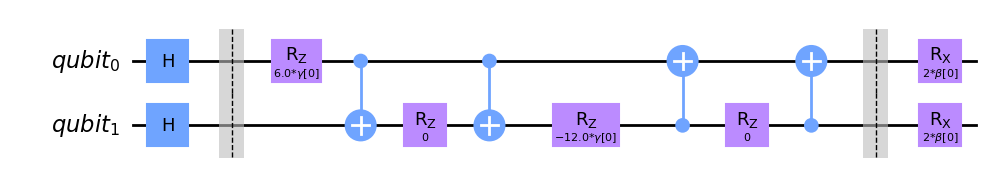

In [64]:
qc = cria_circuito_qaoa_exemplo(reps=1)
qc.draw(output="mpl", style="clifford")

Escrevendo a função objetiva para o `QAOA`

In [68]:
def qaoa_objective(params) -> float:

    qc = cria_circuito_qaoa_exemplo(reps=3)
    qc = qc.assign_parameters(params)
    backend = Aer.get_backend("statevector_simulator")
    resultado = backend.run(qc).result()
    sv = resultado.get_statevector()

    cost_function_value = np.real(np.array(sv)@hamiltonian@np.array(sv))

    return cost_function_value

In [69]:
x0 = [2*np.pi for _ in range(6)]
resultado = scipy.optimize.minimize(fun=qaoa_objective, x0=x0, method="cobyla")

In [70]:
resultado

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -11.998227242003374
       x: [ 7.240e+00  5.023e+00  7.811e+00  7.151e+00  8.036e+00
            7.162e+00]
    nfev: 689
   maxcv: 0.0

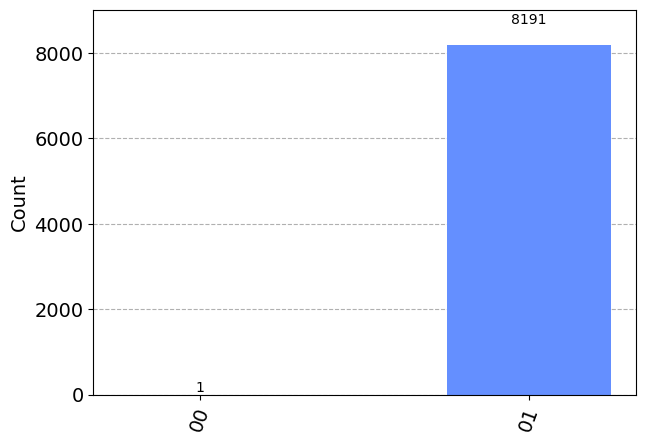

In [71]:
qc = cria_circuito_qaoa_exemplo(reps=3)
qc.measure_all()
qc = qc.assign_parameters(resultado.x)

counts = AerSimulator().run(qc, shots=8192).result().get_counts()

plot_histogram(counts)

In [72]:
def cria_circuito_alternativo_qaoa_exemplo(reps: int=1) -> QuantumCircuit:

    qubit = QuantumRegister(size=2, name="qubit")
    gamma = ParameterVector(name=r"$\gamma$", length=reps)
    beta = ParameterVector(name=r"$\beta$", length=reps)
    qc = QuantumCircuit(qubit)

    qc.h(qubit)
    qc.barrier()
    for i in range(reps):
        qc.rz(hamiltonian[0,0]*gamma[i], qubit[0])
        qc.rzz(theta=hamiltonian[0,1]*gamma[i], qubit1=qubit[0], qubit2=qubit[1])
        qc.rzz(theta=hamiltonian[1,0]*gamma[i], qubit1=qubit[0], qubit2=qubit[1])
        qc.rz(hamiltonian[1,1]*gamma[i], qubit[1])
        qc.barrier()
        for j in range(2):
            qc.rx(theta=2*beta[i], qubit=qubit[j])

    return qc

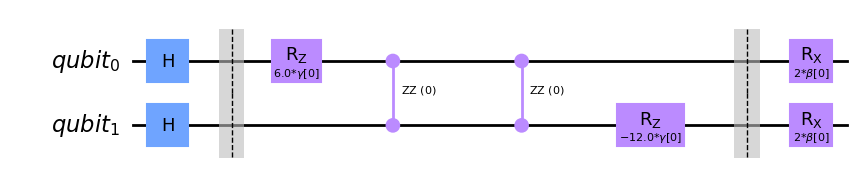

In [73]:
qc = cria_circuito_alternativo_qaoa_exemplo(reps=1)
qc.draw(output="mpl", style="clifford")

In [74]:
def qaoa_objective(params) -> float:

    qc = cria_circuito_alternativo_qaoa_exemplo(reps=3)
    qc = qc.assign_parameters(params)
    backend = Aer.get_backend("statevector_simulator")
    resultado = backend.run(qc).result()
    sv = resultado.get_statevector()

    cost_function_value = np.real(np.array(sv)@hamiltonian@np.array(sv))

    return cost_function_value

In [75]:
x0 = [2*np.pi for _ in range(6)]
resultado = scipy.optimize.minimize(fun=qaoa_objective, x0=x0, method="cobyla")

In [76]:
resultado

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -11.998227242003374
       x: [ 7.240e+00  5.023e+00  7.811e+00  7.151e+00  8.036e+00
            7.162e+00]
    nfev: 689
   maxcv: 0.0

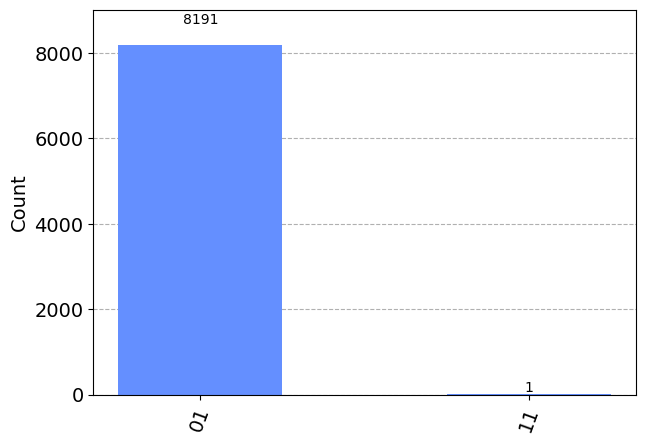

In [77]:
qc = cria_circuito_qaoa_exemplo(reps=3)
qc.measure_all()
qc = qc.assign_parameters(resultado.x)

counts = AerSimulator().run(qc, shots=8192).result().get_counts()

plot_histogram(counts)

### 3.3) Exemplo: Knapsack

O knapsack, também conhecido como problema da mochila, é um problema de otimização bem conhecido e sua formulação mais básica consiste em otimizar o valor total dos itens que serão carregados em uma mochila, de forma que a soma do peso dos itens não supere o peso máximo suportado pela mochila. A formulação matemática do problema pode ser vista abaixo: 

* Caso mais geral

$\max_{x \in \{0,1\}^n} \sum_{i=1}^{n}s_i x_i; \ n \in \mathbb{N}$ 

$\textrm{s.t.} \ \sum_{i=1}^{n}\omega_i x_i \leq c; \ n \in \mathbb{N}$

* Caso específico do exemplo

$\max_{x \in \{0,1\}^4} 5x_1 + 4x_2 + 7x_3 + 2x_4$ 

$\textrm{s.t.} \ 7x_1 + 2x_2 + 1x_3 + 9x_4 \leq 15$

Escrevendo o problema de otimização proposto acima através da classe `Model` do DocPLEX da IBM. 

* Comentários sobre uso do DocPLEX

In [78]:
scores_array = np.array([5, 4, 7, 2])
weights_array = np.array([7, 2, 1, 9])
max_capacity = 15

model_knapsack = Model(name="knapsack")

variables_knapsack = np.array([model_knapsack.binary_var(name=f"x_{i}") for i in range(scores_array.shape[0])])

model_knapsack.minimize(-scores_array.T@variables_knapsack)
model_knapsack.add_constraint(weights_array.T@variables_knapsack <= max_capacity)

docplex.mp.LinearConstraint[](7x_0+2x_1+x_2+9x_3,LE,15)

Visualizando o problema de otimização escrito acima para verificar se está tudo correto.

In [79]:
print(model_knapsack.prettyprint())

// This file has been generated by DOcplex
// model name is: knapsack
// single vars section
dvar bool x_0;
dvar bool x_1;
dvar bool x_2;
dvar bool x_3;

minimize
 - 5 x_0 - 4 x_1 - 7 x_2 - 2 x_3;
 
subject to {
 7 x_0 + 2 x_1 + x_2 + 9 x_3 <= 15;

}
None


Para resolvermos o knapsack utilizando computação quântica, precisamos converter o nosso problema de otimização que é do tipo programação inteira linear, em problema inteiro quadrático, em seguida em problema QUBO (Quadratic Unconstrained Binary Optimization) e por fim em Hamiltoniana de Ising. Para dar início a esse processo, devemos usar a função `from_docplex_mp` do Qiskit Optimization, ela é responsável por converter nosso problema de otimização definido acima, em um problema quadrático.

In [80]:
quad_knapsack = from_docplex_mp(model=model_knapsack)

Visualizando a formulação quadrática do knapsack

In [81]:
print(quad_knapsack.prettyprint())

Problem name: knapsack

Minimize
  -5*x_0 - 4*x_1 - 7*x_2 - 2*x_3

Subject to
  Linear constraints (1)
    7*x_0 + 2*x_1 + x_2 + 9*x_3 <= 15  'c0'

  Binary variables (4)
    x_0 x_1 x_2 x_3



Usando o conversor de problema quadrática para QUBO do Qiskit Optimization (`QuadraticProgramToQubo`), que foi definido no início do notebook e que foi atribuído a variável `converter`.

In [82]:
qubo_knapsack = converter.convert(quad_knapsack)

Visualizando a formulação QUBO do knapsack. Note que agora temos um total de 8 variáveis, em vez das 4 iniciais, houve esse aumento, pois para efetuar as conversões o `QuadraticProgramToQubo` precisou inserir "slack variables" para conseguir realizar as conversões. Outro ponto a se ressaltar aqui, é que agora não temos mais restrições, como é de se esperar de um problema QUBO, isso ocorre porque as restrições são incorporadas a função objetivo através de termos de penalidade.

In [83]:
print(qubo_knapsack.prettyprint())

Problem name: knapsack

Minimize
  19*c0@int_slack@0^2 + 76*c0@int_slack@0*c0@int_slack@1
  + 152*c0@int_slack@0*c0@int_slack@2 + 304*c0@int_slack@0*c0@int_slack@3
  + 76*c0@int_slack@1^2 + 304*c0@int_slack@1*c0@int_slack@2
  + 608*c0@int_slack@1*c0@int_slack@3 + 304*c0@int_slack@2^2
  + 1216*c0@int_slack@2*c0@int_slack@3 + 1216*c0@int_slack@3^2
  + 266*x_0*c0@int_slack@0 + 532*x_0*c0@int_slack@1 + 1064*x_0*c0@int_slack@2
  + 2128*x_0*c0@int_slack@3 + 931*x_0^2 + 532*x_0*x_1 + 266*x_0*x_2
  + 2394*x_0*x_3 + 76*x_1*c0@int_slack@0 + 152*x_1*c0@int_slack@1
  + 304*x_1*c0@int_slack@2 + 608*x_1*c0@int_slack@3 + 76*x_1^2 + 76*x_1*x_2
  + 684*x_1*x_3 + 38*x_2*c0@int_slack@0 + 76*x_2*c0@int_slack@1
  + 152*x_2*c0@int_slack@2 + 304*x_2*c0@int_slack@3 + 19*x_2^2 + 342*x_2*x_3
  + 342*x_3*c0@int_slack@0 + 684*x_3*c0@int_slack@1 + 1368*x_3*c0@int_slack@2
  + 2736*x_3*c0@int_slack@3 + 1539*x_3^2 - 570*c0@int_slack@0
  - 1140*c0@int_slack@1 - 2280*c0@int_slack@2 - 4560*c0@int_slack@3 - 3995*x_0
  - 

* Adicionar comentário sobre o problema ser linear e ser transformado em quadrático e exibir a tabela de penalidades

Para obtermos a Hamiltoniana de Ising que mapeia o problema de otimização de interesse, precisamos usar o método `to_ising()`. Este método retorna uma tupla, onde o primeiro elemento é a Hamiltoniana na forma de um `PauliSumOp` do Qiskit e o segundo termo é o "offset" de energia que deve ser somado ao resultado final, para obter o valor da função objetiva original utilizando as variáeis resposta.

In [84]:
ising, offset = qubo_knapsack.to_ising()

In [85]:
ising

SparsePauliOp(['IIIIIIIZ', 'IIIIIIZI', 'IIIIIZII', 'IIIIZIII', 'IIIZIIII', 'IIZIIIII', 'IZIIIIII', 'ZIIIIIII', 'IIIIIIZZ', 'IIIIIZIZ', 'IIIIZIIZ', 'IIIZIIIZ', 'IIZIIIIZ', 'IZIIIIIZ', 'ZIIIIIIZ', 'IIIIIZZI', 'IIIIZIZI', 'IIIZIIZI', 'IIZIIIZI', 'IZIIIIZI', 'ZIIIIIZI', 'IIIIZZII', 'IIIZIZII', 'IIZIIZII', 'IZIIIZII', 'ZIIIIZII', 'IIIZZIII', 'IIZIZIII', 'IZIIZIII', 'ZIIIZIII', 'IIZZIIII', 'IZIZIIII', 'ZIIZIIII', 'IZZIIIII', 'ZIZIIIII', 'ZZIIIIII'],
              coeffs=[-263.5+0.j,  -74. +0.j,  -34.5+0.j, -341. +0.j,  -38. +0.j,  -76. +0.j,
 -152. +0.j, -304. +0.j,  133. +0.j,   66.5+0.j,  598.5+0.j,   66.5+0.j,
  133. +0.j,  266. +0.j,  532. +0.j,   19. +0.j,  171. +0.j,   19. +0.j,
   38. +0.j,   76. +0.j,  152. +0.j,   85.5+0.j,    9.5+0.j,   19. +0.j,
   38. +0.j,   76. +0.j,   85.5+0.j,  171. +0.j,  342. +0.j,  684. +0.j,
   19. +0.j,   38. +0.j,   76. +0.j,   76. +0.j,  152. +0.j,  304. +0.j])

In [86]:
offset

1112.0

Para obter a resposta ótima para o problema, precisamos fazer o uso do método `compute_minimum_eigenvalue` e passar como argumento a Hamiltoniana de Ising do nosso problema de otimização, como feito abaixo. Neste caso foi utilizado o `NumPyMinimumEigensolver`, este resolve uma equação de autovalor e procura o menor entre os autovalores da matriz. Ele será usado em nosso desafio apenas para guia da resposta que devemos obter usando o VQE ou o QAOA. 

In [87]:
result_knapsack = numpy_solver.compute_minimum_eigenvalue(qubo_knapsack.to_ising()[0])

O valor da função objetiva original é igual ao valor autovalor obtido pelo solver no passo anterior mais o offset do modelo de Ising

In [88]:
result_knapsack.eigenvalue + qubo_knapsack.to_ising()[1]

(-16+0j)

A partir do autoestado, obtemos a bitstring que representa a resposta do nosso problema. Contudo, devemos lembrar que neste caso temos slack variables que não devem ser consideradas na resposta final e que no Qiskit temos um ordenamento invertido da bitstring, sendo assim é preciso inverter a bitstring no pós-processamento.

In [89]:
result_knapsack.eigenstate.to_dict()

{'01010111': (1+0j)}

In [90]:
answer_knapsack = np.array([int(char) for char in list(result_knapsack.eigenstate.to_dict().keys())[0][::-1]])

Resposta correta após o pós-processamento

In [91]:
answer_knapsack[:-4]

array([1, 1, 1, 0])

Criando um ansatz para usar junto ao VQE

* Citar as outras opções de ansatz

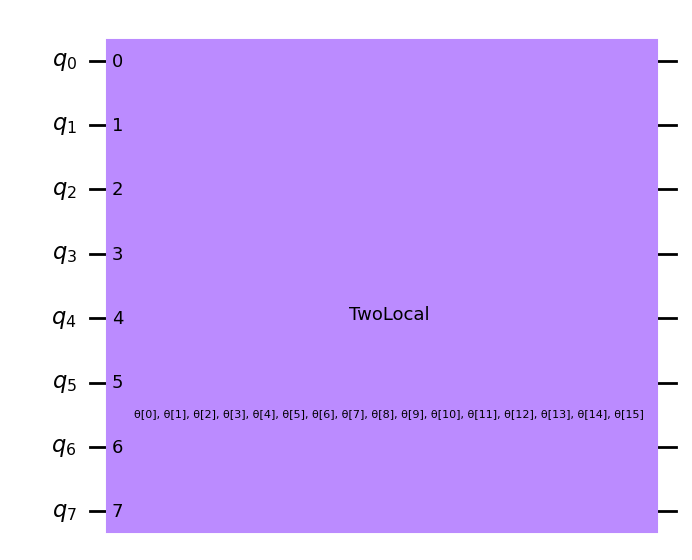

In [92]:
ansatz = TwoLocal(num_qubits=8,
                  rotation_blocks=["ry"],
                  entanglement_blocks="cz",
                  entanglement="full",
                  reps=1,
                  skip_final_rotation_layer=False)

ansatz.draw(output="mpl", style="clifford")

Visualizando o ansatz

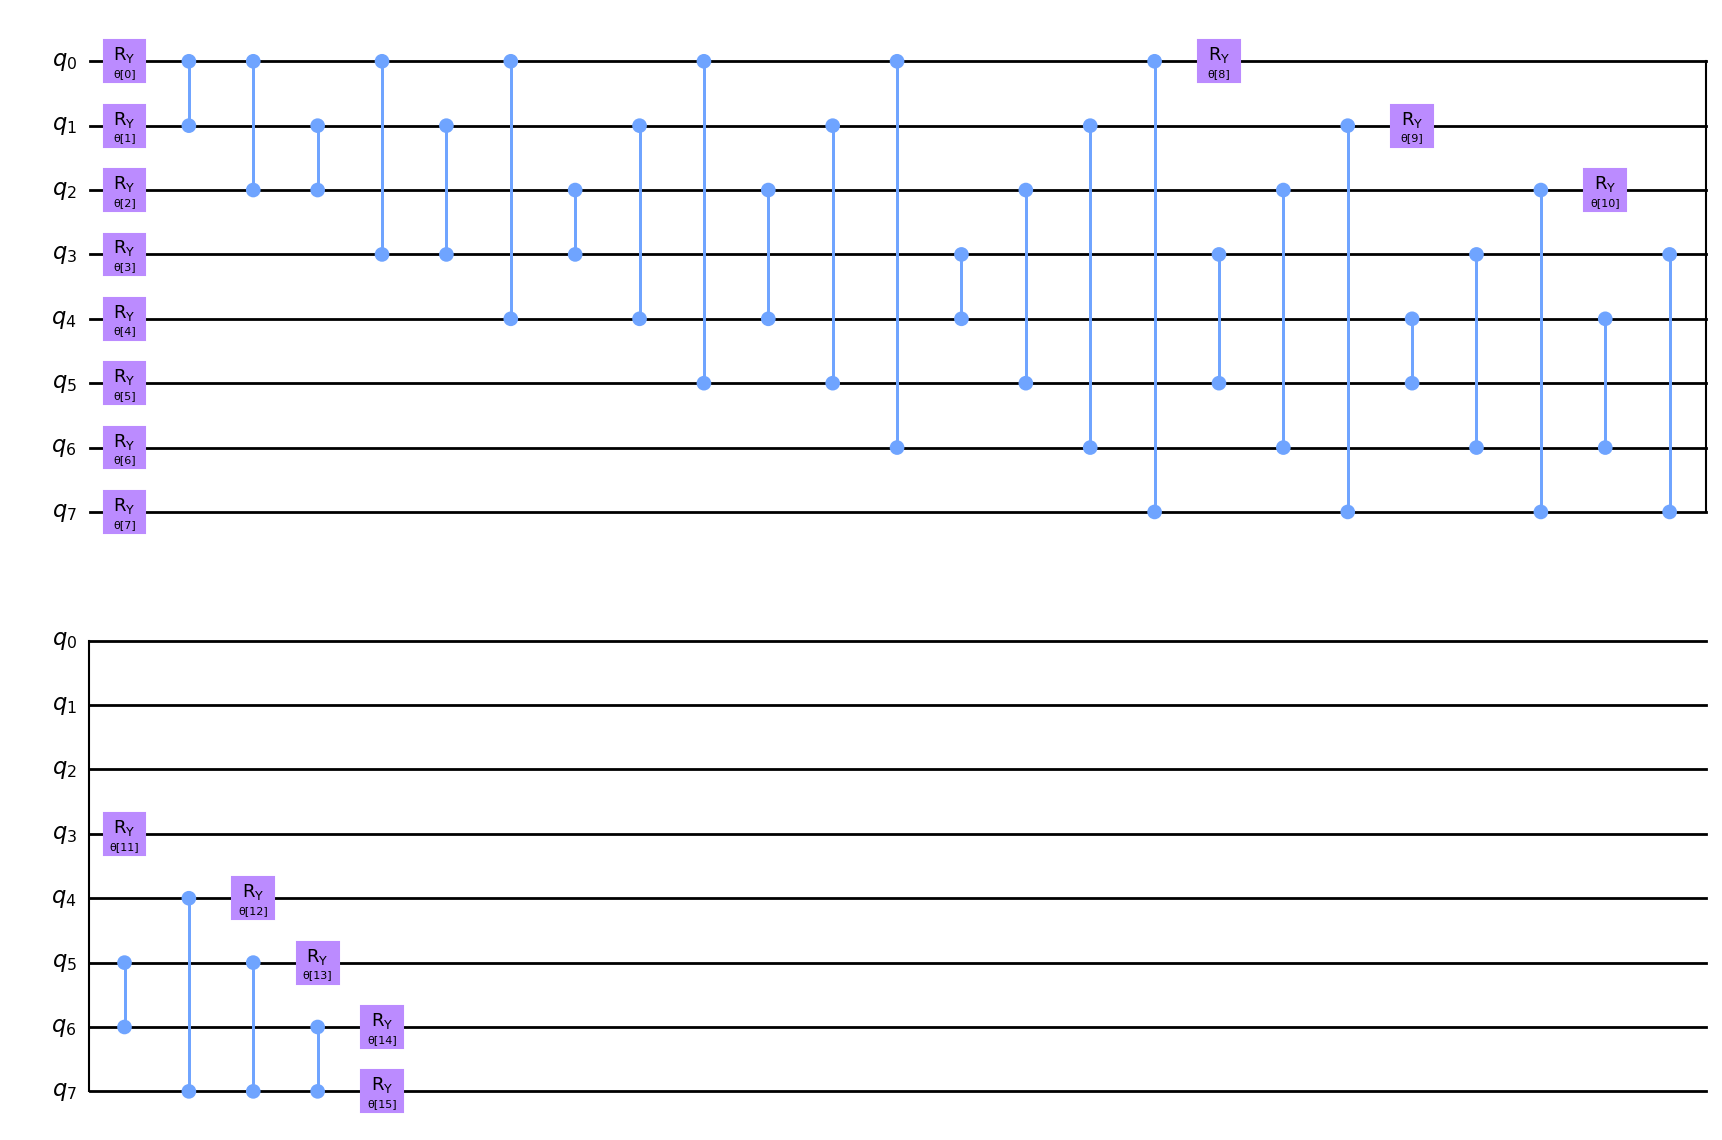

In [93]:
ansatz.decompose().draw(output="mpl", style="clifford")

In [94]:
ansatz.decompose().count_ops()

OrderedDict([('cz', 28), ('ry', 16)])

In [95]:
ansatz.decompose().depth()

15

Inicializando o `VQE`

In [96]:
initial_point = [1 for _ in range(16)]

vqe_solver = VQE(estimator=Estimator(),
                 ansatz=ansatz,
                 optimizer=COBYLA(maxiter=200),
                 initial_point=initial_point)

Usando o método `compute_minimum_eigenvalue` do `VQE` para calcular o menor autovalor da Hamiltoniana que define o problema

In [97]:
resultado_vqe = vqe_solver.compute_minimum_eigenvalue(qubo_knapsack.to_ising()[0])

Recuperando o autoestado associado ao valor obtido

In [98]:
ansatz = ansatz.decompose().assign_parameters(resultado_vqe.optimal_parameters)
ansatz.measure_all()
counts = AerSimulator().run(ansatz, shots=8192).result().get_counts()

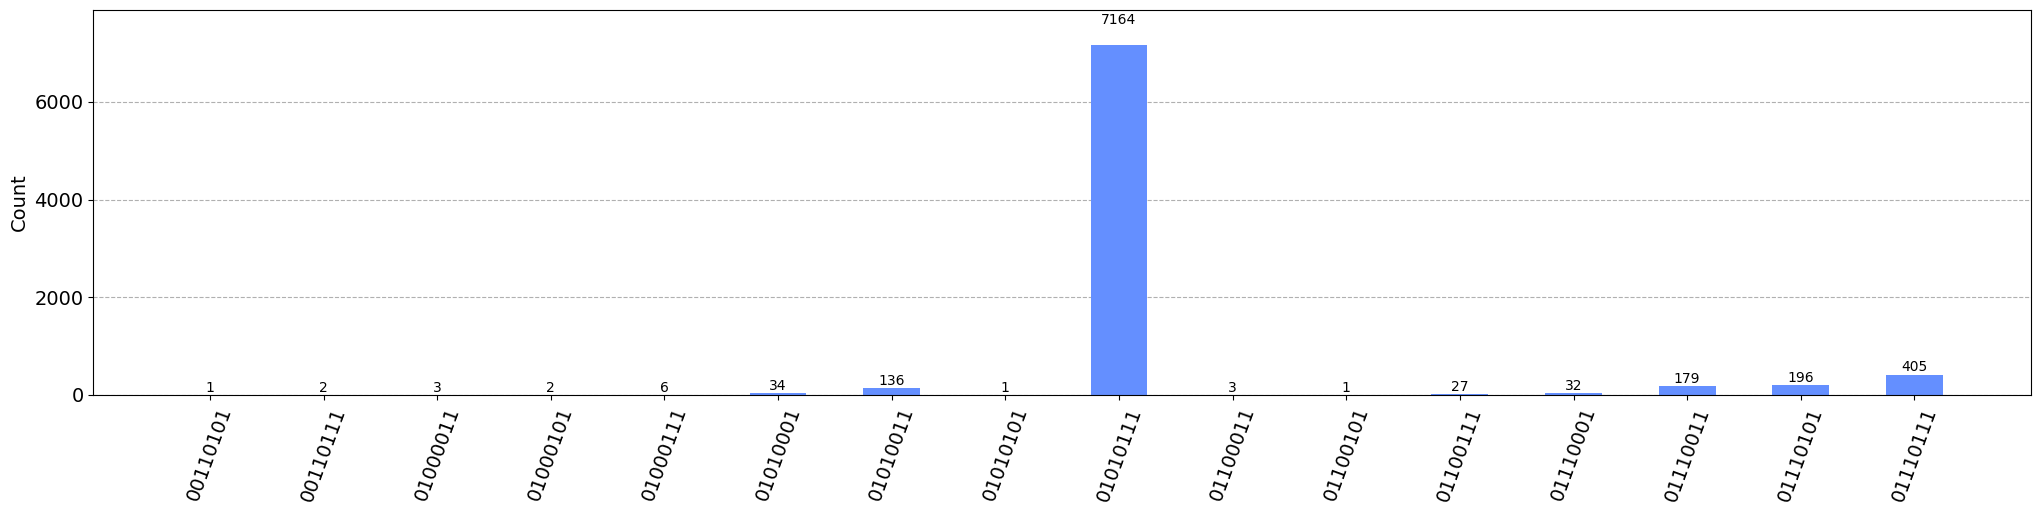

In [99]:
plot_histogram(counts, figsize=(25, 5))

In [100]:
counts_list = list(counts.values())
max_counts = max(counts_list)
max_count_idx = counts_list.index(max_counts)

In [101]:
answer_knapsack_vqe = list(counts.keys())[max_count_idx][::-1]
answer_knapsack_vqe = np.array([int(char) for char in answer_knapsack_vqe[:4]])
print(answer_knapsack_vqe)

[1 1 1 0]


Inicializando o `QAOA`

In [102]:
initial_point = [np.random.random() for _ in range(2)]

qaoa_solver = QAOA(sampler=Sampler(),
                   optimizer=COBYLA(maxiter=200),
                   reps=1,
                   initial_point=initial_point)

Usando o método `compute_minimum_eigenvalue` do `QAOA` para calcular o menor autovalor da Hamiltoniana que define o problema

In [103]:
resultado_qaoa = qaoa_solver.compute_minimum_eigenvalue(qubo_knapsack.to_ising()[0])

Visualizando a melhor resposta

In [104]:
resultado_qaoa.best_measurement

{'state': 87,
 'bitstring': '01010111',
 'value': (-1128+0j),
 'probability': 0.0152969105965188}

O esperado é que a probabilidade de medir a melhor resposta seja a mais próxima possível de 1, para isso precisamos ajustar os parâmetros do `QAOA`, principalmente o número de repetições.

In [105]:
answer_knapsack_qaoa = resultado_qaoa.best_measurement["bitstring"][::-1]
answer_knapsack_qaoa = np.array([int(char) for char in answer_knapsack_qaoa[:4]])
print(answer_knapsack_qaoa[:4])

[1 1 1 0]


In [106]:
qc = resultado_qaoa.optimal_circuit
qc = qc.assign_parameters(resultado_qaoa.optimal_parameters)
qc = qc.decompose().decompose()
qc.measure_all()

In [107]:
counts = backend.run(circuits=qc, shots=10**5).result().get_counts()

In [108]:
counts[resultado_qaoa.best_measurement["bitstring"]]

KeyError: '01010111'

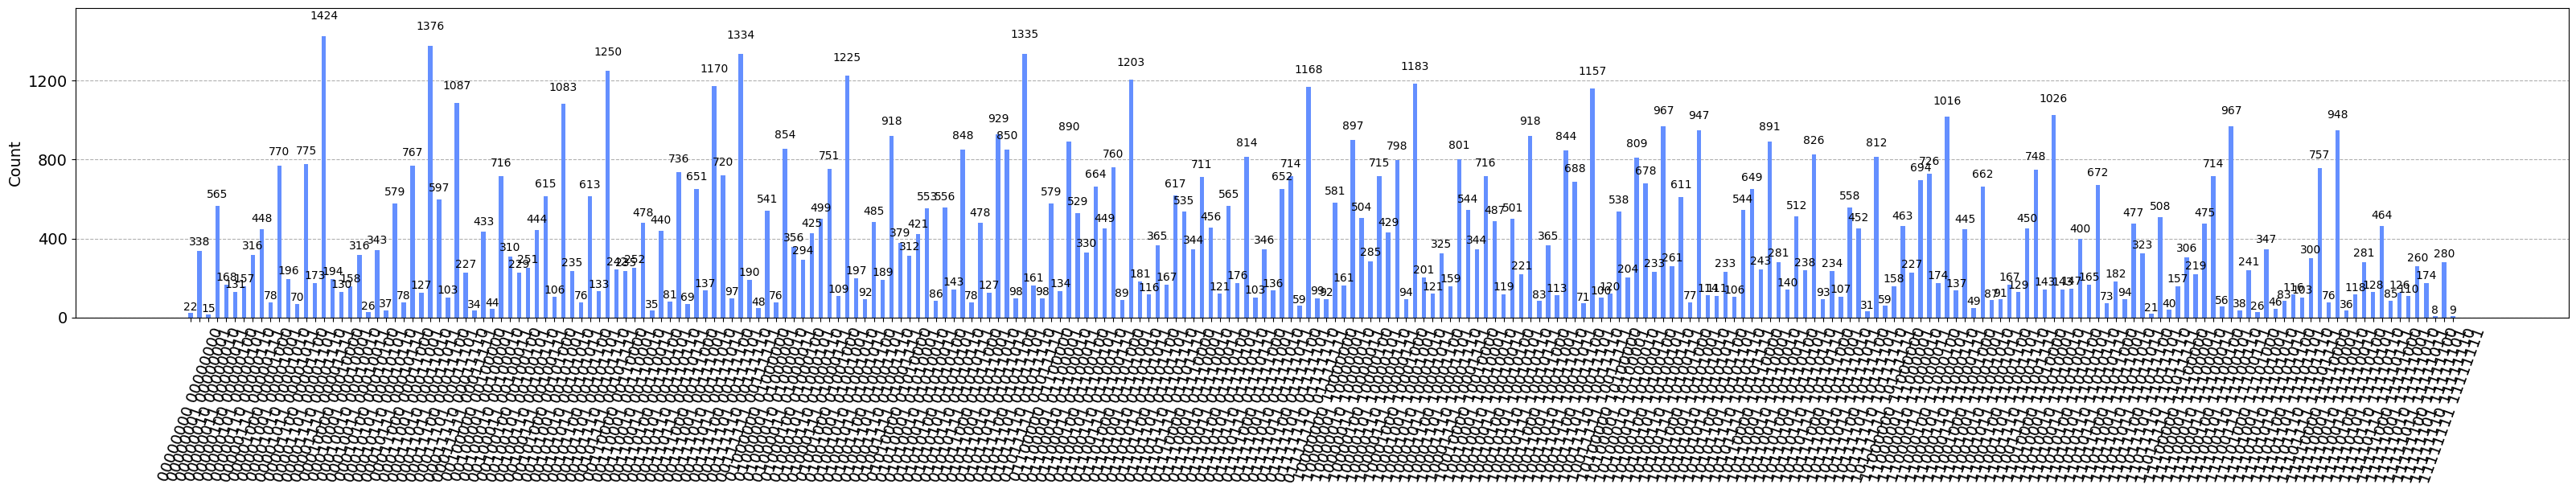

In [109]:
plot_histogram(counts, figsize=(40, 5))

## Limitações para simular classicamente

Simular classicamente a computação quântica é um desafio, tanto do ponto de vista de poder de processamento, quanto do ponto de vista de memória. Abaixo, vamos mostrar que um problema com 55 variáveis + 4 slack variables exige uma quantidade enorme de memória RAM para ser montado e resolvido. Isso se deve, pois em computação quântica lidamos com matrizes de coeficientes complexos de dimensões $2^N$ e $2^N\times 2^N$, o que faz as dimensões escalarem exponencialmente. No exemplo que vamos explorar abaixo, estamos trabalhando com matrizes $2^{59}$ e $2^{59}\times 2^{59}$ ($2^{59} = 576460752303423488$).

In [14]:
scores_array = np.array([np.random.randint(1, 10) for _ in range(55)])
weights_array = np.array([np.random.randint(1, 10) for _ in range(55)])
max_capacity = 15

model_knapsack = Model(name="knapsack")

variables_knapsack = np.array([model_knapsack.binary_var(name=f"x_{i}") for i in range(scores_array.shape[0])])

model_knapsack.minimize(-scores_array.T@variables_knapsack)
model_knapsack.add_constraint(weights_array.T@variables_knapsack <= max_capacity)

docplex.mp.LinearConstraint[](6x_0+7x_1+7x_2+3x_3+8x_4+7x_5+5x_6+x_7+7x_8+2x_9+x_10+x_11+8x_12+2x_13+9x_14+4x_15+7x_16+7x_17+4x_18+2x_19+x_20+7x_21+x_22+3x_23+2x_24+2x_25+7x_26+4x_27+6x_28+6x_29+3x_30+7x_31+7x_32+5x_33+5x_34+2x_35+5x_36+x_37+4x_38+6x_39+4x_40+6x_41+7x_42+6x_43+4x_44+4x_45+9x_46+9x_47+3x_48+9x_49+2x_50+7x_51+3x_52+6x_53+5x_54,LE,15)

In [15]:
quad_knapsack = from_docplex_mp(model=model_knapsack)

In [18]:
qubo_knapsack = converter.convert(quad_knapsack)

In [19]:
print(qubo_knapsack.prettyprint())

Problem name: knapsack

Minimize
  269*c0@int_slack@0^2 + 1076*c0@int_slack@0*c0@int_slack@1
  + 2152*c0@int_slack@0*c0@int_slack@2 + 4304*c0@int_slack@0*c0@int_slack@3
  + 1076*c0@int_slack@1^2 + 4304*c0@int_slack@1*c0@int_slack@2
  + 8608*c0@int_slack@1*c0@int_slack@3 + 4304*c0@int_slack@2^2
  + 17216*c0@int_slack@2*c0@int_slack@3 + 17216*c0@int_slack@3^2
  + 3228*x_0*c0@int_slack@0 + 6456*x_0*c0@int_slack@1 + 12912*x_0*c0@int_slack@2
  + 25824*x_0*c0@int_slack@3 + 9684*x_0^2 + 22596*x_0*x_1 + 3228*x_0*x_10
  + 3228*x_0*x_11 + 25824*x_0*x_12 + 6456*x_0*x_13 + 29052*x_0*x_14
  + 12912*x_0*x_15 + 22596*x_0*x_16 + 22596*x_0*x_17 + 12912*x_0*x_18
  + 6456*x_0*x_19 + 22596*x_0*x_2 + 3228*x_0*x_20 + 22596*x_0*x_21
  + 3228*x_0*x_22 + 9684*x_0*x_23 + 6456*x_0*x_24 + 6456*x_0*x_25
  + 22596*x_0*x_26 + 12912*x_0*x_27 + 19368*x_0*x_28 + 19368*x_0*x_29
  + 9684*x_0*x_3 + 9684*x_0*x_30 + 22596*x_0*x_31 + 22596*x_0*x_32
  + 16140*x_0*x_33 + 16140*x_0*x_34 + 6456*x_0*x_35 + 16140*x_0*x_36
  + 3228

In [21]:
result_knapsack = numpy_solver.compute_minimum_eigenvalue(qubo_knapsack.to_ising()[0])

MemoryError: Unable to allocate 2.00 EiB for an array with shape (576460752303423488,) and data type uint32

Esse problema em específico nos permite trabalhar com `uint32`, o que nos ajuda no consumo de RAM, mas mesmo assim, devido a dimensão do problema, são exigidos $2$ exabytes de memória RAM ($1$ exabyte = $10^9$ gigabytes). Essa quantidade de memória é 0.5 exabyte menor do que a quantidade de informação que é criada no planeta Terra todos os dias de acordo com a seguinte matéria da revista Forbes (https://www.forbes.com/sites/bernardmarr/2018/05/21/how-much-data-do-we-create-every-day-the-mind-blowing-stats-everyone-should-read/?sh=53f2deed60ba). Devido a isso, projeta-se que os computadores quânticos trabalharão lado a lado com supercomputadores ou que a gente consiga transferir a parte clássica da rotina dos algoritmos quânticos variacionais para os computadores quânticos, mas para isso precisamos atingir o nível de tolerância a erros.

![image](https://media.tenor.com/B7vSc-79QXAAAAAd/mindblow-mind-explosion.gif)

Felizmente, nem tudo está perdido, pois no Qiskit temos um simulador de MPS (Matrix Product State) que nos permite simular esses cenários com muitos qubits, contudo pode ser que o processo demore um tempo considerável. Abaixo segue um exemplo de como utilizar esse recurso.

In [22]:
backend = AerSimulator(method="matrix_product_state")
backend_sampler = BackendSampler(backend=backend)

In [23]:
qaoa_solver = QAOA(sampler=backend_sampler,
                   optimizer=COBYLA(maxiter=500),
                   reps=1,
                   initial_point=None)

In [24]:
resultado_qaoa = qaoa_solver.compute_minimum_eigenvalue(qubo_knapsack.to_ising()[0])

## Referências

1. Alleviating the quantum Big-M problem (https://arxiv.org/abs/2307.10379)
2. A Tutorial on Formulating and Using QUBO Models (https://arxiv.org/abs/1811.11538)
3. Artigo na Wikipedia "Quadratic unconstrained binary optimization" (https://en.wikipedia.org/wiki/Quadratic_unconstrained_binary_optimization)
4. Artigo na Wikipedia "Ising model" (https://en.wikipedia.org/wiki/Ising_model)
5. Qiskit Textbook chapter: Simulating Molecules using VQE (https://learn.qiskit.org/course/ch-applications/simulating-molecules-using-vqe)
6. Qiskit Textbook chapter: Solving combinatorial optimization problems using QAOA (https://learn.qiskit.org/course/ch-applications/solving-combinatorial-optimization-problems-using-qaoa)
7. IBM Quantum Course: Variational Algorithm Design: (https://learning.quantum.ibm.com/course/variational-algorithm-design)

In [102]:
import qiskit.tools.jupyter

%qiskit_version_table